In [23]:
#READ ME
# In this document simulated data of a scatter event is analyzed
# This is done on single events and on all events in a larger analysis
# In cell 6, the number of events can be set.
# Here the choice between showing the anaylisis for a single event or the analysis on all events together

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-23-dcb345a1824a>, line 2)

In [1]:
import strax
import straxen
from strax import *
import numpy as np
#from plot_patterns import plot_pattern
import matplotlib.pyplot as plt
import cProfile
import time
from line_profiler import LineProfiler
import math
import LinPosFit as LinPosFit

2021-08-18 13:48:04,180 - utilix - WARNING - Refreshing token failed for some reason, so making a  new one


In [2]:
# geometry
#
inch = 2.54 # cm
pmt_surface=(3*inch)**2*np.pi/4.
pmt_to_lxe = 7.25
npmt_top_array = 253#494

In [3]:
import pickle
# OLD: https://xe1t-wiki.lngs.infn.it/doku.php?id=xenon:xenonnt:terliuk:wfsim_s2_training_patterns
# NEW: https://xe1t-wiki.lngs.infn.it/doku.php?id=xenon:xenonnt:terliuk:posrec_training_patterns_wfsim
data = pickle.load(open("/data/xenon/xenonnt_mc/reconstructed_S2_2000005.pckl", "rb"))

# filename =  '/project2/lgrandi/terliuk/MCoutputs/WFsim_patterns/disk_meshes/A_const_10__Z_const_-1/WFsim_A_const_10__Z_const_-1_N10000_000000.hdf5'

In [4]:
#
# get the true MC positions
#
True_pos = data['true_pos']
#
# get the S2 size
#
mc_amplitude = data['amplitude']
#
# get the CNN reconstructed position
#
cnn_pos = data['reco_S2_2000005_axial']
#
# area measured on each PMT
#
area_per_channel = data['area_per_channel']
#
# get the positions of each PMT
#
pmt_pos = straxen.pmt_positions()
pmt_pos  = list(zip(pmt_pos['x'].values,pmt_pos['y'].values,np.repeat(pmt_to_lxe, npmt_top_array)))

pmt_pos = np.array(pmt_pos)


In [6]:
%%time
# define the results data structure

# set the number of events to be analyzed
number_of_events = 100000#len(corr_pos)

# display the events or not?
display = False


aantal_foton = []
tijd_lijst = []
res=np.zeros(number_of_events,dtype=[('xml',np.float),
                                  ('yml',np.float),
                                  ('r0',np.float), 
                                  ('gamma', np.float),
                                  ('logl',np.float), 
                                  ('n',np.int), 
                                  ('x00',np.float),
                                  ('y00',np.float),
                                  ('xst',np.float),
                                  ('yst',np.float),
                                  ('xmc',np.float),
                                  ('ymc',np.float),
                                  ('Imc',np.float),
                                  ('nuv',np.float)])

#
# loop over the events
#
for ip in range(number_of_events):
    #
    # get the measured area in each of the PMTs
    #
    
    nhit_lijst = area_per_channel[ip][:253]    
    nhit = np.array(nhit_lijst)
    aantal_hits = nhit.tolist()
    aantal_foton.append(len(aantal_hits))
    #
    # do the position fit and retrieve the results
    #
    begin = time.time()
    fit_result,xiter,used_hits = LinPosFit.lpf_execute(pmt_pos,nhit,pmt_surface)
    end = time.time()
    verschil = end-begin
    tijd_lijst.append(verschil)
    #
    # store the result
    #
    res[ip]['xml'] = fit_result[0]
    res[ip]['yml'] = fit_result[1]
    res[ip]['r0'] = fit_result[2]
    res[ip]['logl'] = fit_result[3]
    res[ip]['n'] = fit_result[4]
    res[ip]['gamma'] = fit_result[5]
    res[ip]['nuv'] = fit_result[6]

    res[ip]['x00'] = xiter[0][0]
    res[ip]['y00'] = xiter[0][1]
    res[ip]['xst'] = cnn_pos[ip][0]
    res[ip]['yst'] = cnn_pos[ip][1]

    res[ip]['xmc'] = True_pos[ip][0]
    res[ip]['ymc'] = True_pos[ip][1]
    res[ip]['Imc'] = mc_amplitude[ip]  
        #print(ix, p['time'], ' ',int(truth.iloc[imc].time/100000000))
        
    #event display
    istatus = 0
    if display:
        LinPosFit.verschil(pmt_pos,nhit,res[ip]['xml'],res[ip]['yml'],fit_result[6],res[ip]['gamma'])
        print('--- x_mc =',res[ip]['xmc'],' y_mc =',res[ip]['ymc'])
        print('--- x_lf =',fit_result[0],' y_lf =',fit_result[1],' r0 =',fit_result[2],' gamma =',fit_result[5],' nh =',fit_result[4],' logl =',fit_result[3])
        istatus = LinPosFit.lpf_event_display(pmt_pos, nhit, fit_result, used_hits, xiter, range=((-100.,100.),(-100,100)), zoom=0 )
        if istatus == 2:
            break

CPU times: user 2min 19s, sys: 593 ms, total: 2min 19s
Wall time: 5min 5s


In [7]:
#
# here I make a selection on the results..... (if I want)
#

res1=res[np.sqrt(res['xmc']**2+res['ymc']**2)<100]
res1=res1[res1['Imc']>1000]

#
# but I do not have to
#
###res1 = res

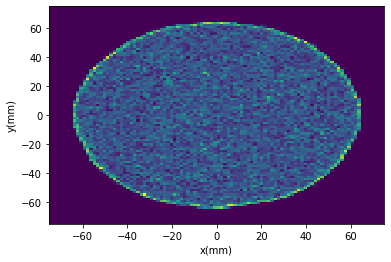

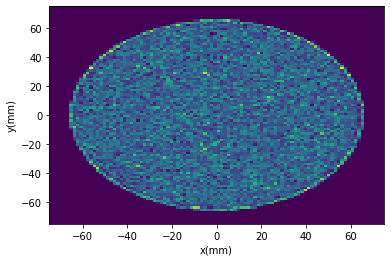

In [8]:
# 2d histogram of the amount of hits in the tank for the likelihood fit
h2 = plt.hist2d(res1['xml'],res1['yml'],bins=(100,100), range=((-75,75),(-75,75)))
plt.xlabel('x(mm)')
plt.ylabel('y(mm)')
plt.show()

# 2d histogram of the amount of hits in the tank for the neural network
h2 = plt.hist2d(res1['xst'],res1['yst'],bins=(100,100), range=((-75,75),(-75,75)))
plt.xlabel('x(mm)')
plt.ylabel('y(mm)')
plt.show()

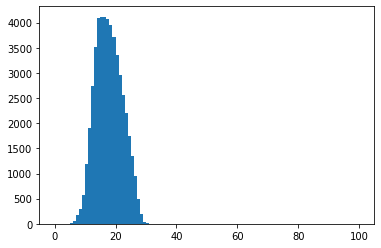

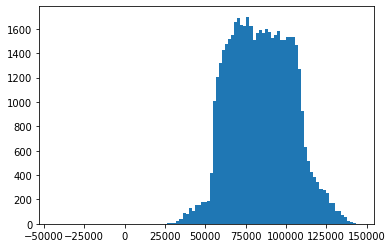

In [9]:
# histogram of the values of gamma
plt.hist(res1['gamma'],bins=100,range=(0,100))
plt.show()

# histogram of the values of r0
plt.hist(res1['r0'],bins=100)
plt.show()

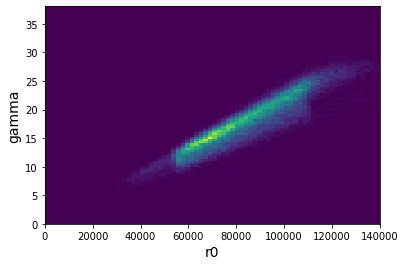

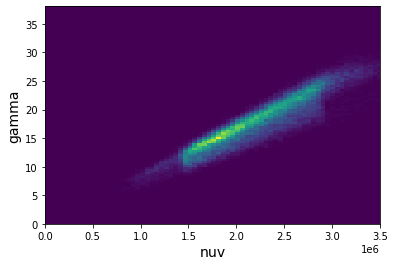

In [10]:
# plot of r0 and gamma
plt.hist2d(res1['r0'],res1['gamma'],bins=(100,100))
plt.xlim(0,140000)
plt.xlabel("r0",fontsize=14)
plt.ylabel("gamma",fontsize=14)
plt.show()

# plot of number of photons and gamma
plt.hist2d(res1['nuv'],res1['gamma'],bins=(100,100))
plt.xlim(0,3500000)
plt.xlabel("nuv",fontsize=14)
plt.ylabel("gamma",fontsize=14)
plt.show()

In [11]:
# different values of r and r squared are calculated
r2mc = res1['xmc']**2+res1['ymc']**2
rmc = np.sqrt(r2mc)
r2ml = res1['xml']**2+res1['yml']**2
rml = np.sqrt(r2ml)
r2st = res1['xst']**2+res1['yst']**2
rst = np.sqrt(r2st)
r200 = res1['x00']**2+res1['y00']**2
r00 = np.sqrt(r200)

# specific lists are made
xmc_lijst = res1['xmc']
ymc_lijst = res1['ymc']
xml_lijst = res1['xml']
yml_lijst = res1['yml']
xst_lijst = res1['xst']
yst_lijst = res1['yst']

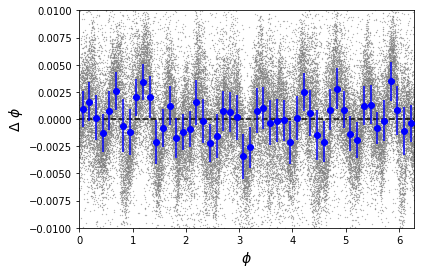

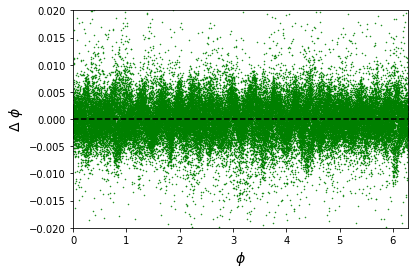

In [12]:
# lists are made for the montecarlo data set
rmc_lijst = list(rmc)
mc_x_lijst = list(res1['xmc'])
mc_y_lijst = list(res1['ymc'])
phi_mc_lijst = []

# the value of phi is calculated based on it's x and y position for monte carlo data
for iiiii in range(len(rmc_lijst)):
    if mc_x_lijst[iiiii] > 0 and mc_y_lijst[iiiii] > 0:
        phi_mc_lijst.append(math.atan(abs(mc_y_lijst[iiiii]/mc_x_lijst[iiiii])))
    if mc_x_lijst[iiiii] < 0 and mc_y_lijst[iiiii] > 0:
        phi_mc_lijst.append(math.pi - math.atan(abs(mc_y_lijst[iiiii]/mc_x_lijst[iiiii])))       
    if mc_x_lijst[iiiii] < 0 and mc_y_lijst[iiiii] < 0:
        phi_mc_lijst.append(math.pi + math.atan(abs(mc_y_lijst[iiiii]/mc_x_lijst[iiiii])))        
    if mc_x_lijst[iiiii] > 0 and mc_y_lijst[iiiii] < 0:
        phi_mc_lijst.append((2*math.pi) -math.atan(abs( mc_y_lijst[iiiii]/mc_x_lijst[iiiii])))

# lists are made for the position reconstruction
rml_lijst = list(rml)
ml_x_lijst = list(res1['xml'])
ml_y_lijst = list(res1['yml'])
phi_ml_lijst = []

# the value of phi is calculated based on it's x and y positionfor the calculated position
for iiiiii in range(len(rml_lijst)):
    if ml_x_lijst[iiiiii] > 0 and ml_y_lijst[iiiiii] > 0:
        phi_ml_lijst.append(math.atan(abs(ml_y_lijst[iiiiii]/ml_x_lijst[iiiiii])))
    if ml_x_lijst[iiiiii] < 0 and ml_y_lijst[iiiiii] > 0:
        phi_ml_lijst.append(math.pi - math.atan(abs(ml_y_lijst[iiiiii]/ml_x_lijst[iiiiii])))       
    if ml_x_lijst[iiiiii] < 0 and ml_y_lijst[iiiiii] < 0:
        phi_ml_lijst.append(math.pi + math.atan(abs(ml_y_lijst[iiiiii]/ml_x_lijst[iiiiii])))        
    if ml_x_lijst[iiiiii] > 0 and ml_y_lijst[iiiiii] < 0:
        phi_ml_lijst.append((2*math.pi) - math.atan(abs(ml_y_lijst[iiiiii]/ml_x_lijst[iiiiii])))
  
# filters out unalligned events
lll_lijst = []
for lll in range(len(phi_mc_lijst)):
    if phi_mc_lijst[lll] - phi_ml_lijst[lll]> 0.02 or phi_mc_lijst[lll] - phi_ml_lijst[lll]< -0.02:
        lll_lijst.append(lll)

# remove the weird events from the lists        
phi_r_plaate_array_ml = np.asarray(phi_ml_lijst)
phi_r_plaate_array_mc = np.asarray(phi_mc_lijst)  
lll_lijst.reverse()
for ppp in range(len(lll_lijst)):
    phi_mc_lijst.pop(lll_lijst[ppp])
    phi_ml_lijst.pop(lll_lijst[ppp])

# turns lists into arrays
phi_ml_array1 = np.asarray(phi_ml_lijst)
phi_mc_array1 = np.asarray(phi_mc_lijst)
    
# sorts the events and creates a Chebyshev fit    
phi_ml_array  = np.array(sorted(phi_ml_lijst, reverse=False)) 
phi_mc_array = np.array([x for _,x in sorted(zip(phi_ml_lijst,phi_mc_lijst))])
fout_array = phi_mc_array - phi_ml_array
chebyfit_phi = np.polynomial.chebyshev.Chebyshev.fit(phi_mc_array, fout_array, 40)

# bins the events and creates errors on the bins
nbins3 = 50
n2, ___ = np.histogram(phi_mc_array, bins=nbins3)
sy2, ___ = np.histogram(phi_mc_array, bins=nbins3, weights=(phi_mc_array-phi_ml_array))
sy22, ___ = np.histogram(phi_mc_array, bins=nbins3, weights=(phi_mc_array-phi_ml_array)*(phi_mc_array-phi_ml_array))
mean2 = sy2 / n2
std2 = np.sqrt(sy22/n2 - mean2*mean2) /2

# plots the error on phi with the binned events as well
plt.plot((phi_mc_array),(phi_mc_array-phi_ml_array),'.',color='grey',markersize = 0.5)
plt.errorbar((___[1:] + ___[:-1])/2, mean2, yerr=std2, fmt='bo',zorder=3) 
#plt.plot(phi_mc_array, chebyfit_phi(phi_mc_array),color = 'red')
plt.xlabel('$\phi$',fontsize=14)
plt.ylabel('$\Delta$ $\phi$',fontsize=14)
plt.plot([0,2*math.pi],[0,0],'--',color = 'black')
plt.ylim([-0.01,0.01])
plt.xlim([0,2*math.pi])
plt.show()

# plots the corrected values after the Chebyshev correction
plt.plot(phi_mc_array, phi_mc_array - phi_ml_array - chebyfit_phi(phi_mc_array), '.', color = 'green', markersize = 1)
plt.xlabel('$\phi$',fontsize=14)
plt.ylabel('$\Delta$ $\phi$',fontsize=14)
plt.plot([0,2*math.pi],[0,0],'--',color = 'black')
plt.ylim([-0.02,0.02])
plt.xlim([0,2*math.pi])
plt.show()

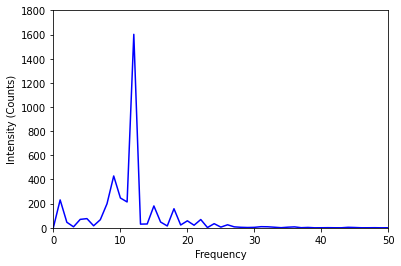

In [13]:
# Create a fourrier transformation on the data and determine the frequency
# Work In Progress
from scipy.fft import fft

# tries to forurier transform the data
verschil_phi_array = phi_mc_array - phi_ml_array
fourier_transform = np.fft.rfft(verschil_phi_array)
abs_fourier_transform = np.abs(fourier_transform)
power_spectrum = np.square(abs_fourier_transform)

# plots the power spectrum
plt.plot(power_spectrum, color = 'blue')
plt.xlim(0,50)
plt.ylim(0,1800)
plt.xlabel("Frequency")
plt.ylabel("Intensity (Counts)")
plt.show()

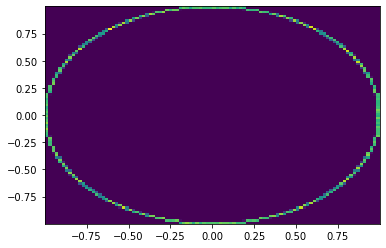

In [14]:
# Look at any systematic biases in the phi value
x_array_phi = []
y_array_phi = []
phi_ml_lijst = list(phi_ml_array)

# loops through the values for phi
for mmm in range(len(phi_ml_lijst)):
    x_array_phi.append(math.cos(phi_ml_lijst[mmm]))
    y_array_phi.append(math.sin(phi_ml_lijst[mmm]))

# plots phi on a 2d histogram
plt.hist2d(x_array_phi,y_array_phi,bins=(100,100))
plt.show()

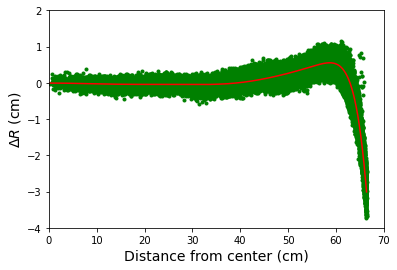

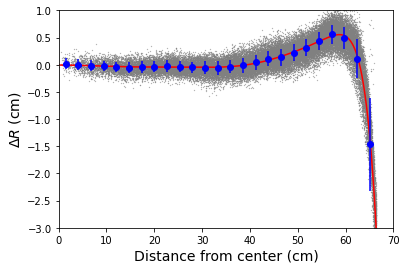

In [15]:
# create lists to calculate the future fit on
r2mc_list = r2mc.tolist()
fit_array = rml-rmc
fit_lijst = fit_array.tolist()
rmc_list = rmc.tolist()

# filters out large outliers to make the error bars more accurate
for jj in range(len(fit_lijst)):
    if fit_lijst[jj] < -6:
        fit_lijst[jj] = fit_lijst[jj-1]

# sorts all the lists on bases of smallest to largest r
xmc_lijst = np.array([x for _,x in sorted(zip(r2mc_list,xmc_lijst))])
ymc_lijst = np.array([x for _,x in sorted(zip(r2mc_list,ymc_lijst))])
xml_lijst = np.array([x for _,x in sorted(zip(r2mc_list,xml_lijst))])
yml_lijst = np.array([x for _,x in sorted(zip(r2mc_list,yml_lijst))])
xst_lijst = np.array([x for _,x in sorted(zip(r2mc_list,xst_lijst))])
yst_lijst = np.array([x for _,x in sorted(zip(r2mc_list,yst_lijst))])
fout_lijst  =np.array([x for _,x in sorted(zip(r2mc_list,fit_lijst))])
r2_lijst  = np.array(sorted(r2mc_list, reverse=False))
rmc_lijst = np.array(sorted(rmc_list, reverse=False))
# r2_lijst = np.array(r2_lijst)
# fout_lijst= np.array(fout_lijst)

# creates fit on the dataset 
chebyfit = np.polynomial.chebyshev.Chebyshev.fit(r2_lijst, fout_lijst, 7)

# plots the raw data with the fit through it        
plt.plot(rmc_lijst,fout_lijst,'.',color= 'green')
plt.plot(rmc_lijst, chebyfit(r2_lijst),color = 'red')
plt.ylim(-4,2)
plt.xlim(0,70)
plt.xlabel('Distance from center (cm)',fontsize=14)
plt.ylabel('$\Delta R$ (cm)',fontsize=14)
plt.show()

# bins the dataset and creates error bars
nbins = 25
n, _ = np.histogram(rmc_lijst, bins=nbins)
sy, _ = np.histogram(rmc_lijst, bins=nbins, weights=fout_lijst)
sy2, _ = np.histogram(rmc_lijst, bins=nbins, weights=fout_lijst*fout_lijst)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)
correctie_list = (mean - chebyfit(((_[1:] + _[:-1])/2)**2))/std

# calculates sigma on each datapoint
correctie_lijst = list(correctie_list)
gemiddelde = sum(correctie_lijst)/len(correctie_lijst)
somatie = 0
for jjj in range(len(correctie_lijst)):
    somatie = somatie + ((correctie_lijst[jjj] - gemiddelde)**2)
sigma = (somatie / len(correctie_lijst))**0.5
correctie_list = correctie_lijst / sigma

# plots the binned dataset
plt.plot(rmc_lijst,fout_lijst,'.',color= 'grey',markersize = 0.5)
plt.plot(rmc_lijst, chebyfit(r2_lijst),color = 'red',label='Chebyshev fit')
plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='bo',label= 'Error on results',zorder=3)
plt.ylim(-3,1)
plt.xlim(0,70)
plt.xlabel('Distance from center (cm)',fontsize=14)
plt.ylabel('$\Delta R$ (cm)',fontsize=14)
plt.show()

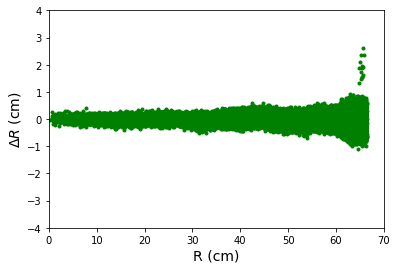

[-0.2476795  -0.5632841  -0.7460103  -0.69439122 -0.42307763 -0.21099603
 -0.09071038 -0.03229515]


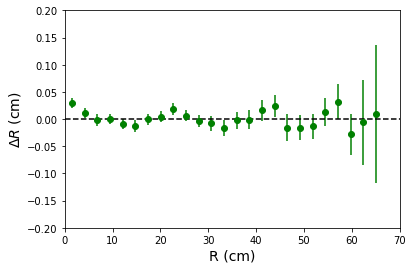

In [16]:
# plots the corrected error on r after using the chebyshev fit
plt.plot(rmc_lijst,fout_lijst-chebyfit(r2_lijst),'.',color= 'green')
plt.ylim(-4,4)
plt.xlim(0,70)
plt.xlabel('R (cm)',fontsize=14)
plt.ylabel('$\Delta R$ (cm)',fontsize=14)
plt.show()
print(chebyfit.coef)

# bins the data points of the corrected data
nbins = 25
n1, __ = np.histogram(rmc_lijst, bins=nbins)
sy1, __ = np.histogram(rmc_lijst, bins=nbins, weights=(fout_lijst-chebyfit(r2_lijst)))
sy21, __ = np.histogram(rmc_lijst, bins=nbins, weights=(fout_lijst-chebyfit(r2_lijst))*(fout_lijst-chebyfit(r2_lijst)))
mean1 = sy1 / n1
std1 = (sy21/n1 - mean1*mean1)

# plots the corrected data in fewer points with error bars
plt.errorbar((__[1:] + __[:-1])/2, mean1, yerr=std1, fmt='go')
plt.ylim(-0.2,0.2)
plt.xlim(0,70)
plt.xlabel('R (cm)',fontsize=14)
plt.ylabel('$\Delta R$ (cm)',fontsize=14)
plt.plot([0,70],[0,0],'--',color='black')
plt.show()

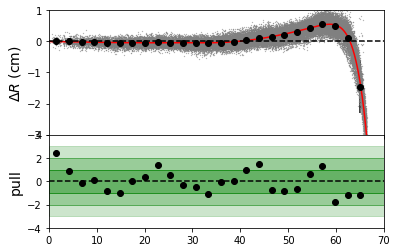

In [17]:
import matplotlib.patches as patches

# shows the data points with the fit and the pull on each data point
fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 3]})
axs[0].plot(rmc_lijst,fout_lijst,'.',color= 'grey',markersize = 0.5)
axs[0].errorbar((_[1:] + _[:-1])/2, mean, yerr=std,color= 'black', ecolor='black', fmt='o')
axs[0].plot(rmc_lijst, chebyfit(r2_lijst),color = 'red')
axs[0].set_ylim(-3,1)
axs[0].set_xlim(0,70)
axs[0].set_ylabel('$\Delta R$ (cm)',fontsize=14)
axs[0].plot([0,70],[0,0],'--',color = 'black')
axs[1].plot((_[1:] + _[:-1])/2, correctie_list, 'o',color= 'black')
axs[1].plot([0,70],[0,0],'--',color = 'black')
axs[1].add_patch(patches.Rectangle((0,-1), 70, 2, color="green",alpha= 0.6))
axs[1].add_patch(patches.Rectangle((0,1), 70, 1, color="green",alpha= 0.4))
axs[1].add_patch(patches.Rectangle((0,-2), 70, 1, color="green",alpha= 0.4))
axs[1].add_patch(patches.Rectangle((0,2), 70, 1, color="green",alpha= 0.2))
axs[1].add_patch(patches.Rectangle((0,-3), 70, 1, color="green",alpha= 0.2))
axs[1].set_ylabel('pull',fontsize=14)
axs[1].set_ylim(-4,4)
axs[1].set_xlim(0,70)
plt.subplots_adjust(wspace=0, hspace=0)

# remove the x values on the middle line
for ax in axs:
    ax.label_outer()

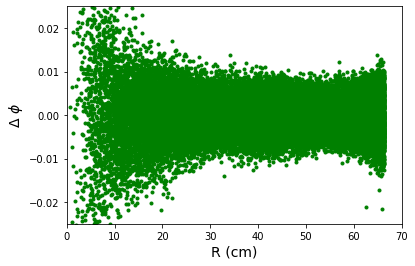

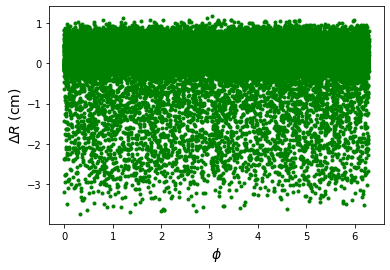

In [18]:
# plots the error on phi against R
plt.plot(rmc,phi_r_plaate_array_mc-phi_r_plaate_array_ml, 'g.')
plt.ylim(-0.025,0.025)
plt.xlim(0,70)
plt.ylabel('$\Delta$ $\phi$',fontsize=14)
plt.xlabel('R (cm)',fontsize=14)
plt.show()

# plots the error on R against phi
plt.plot(phi_r_plaate_array_mc,fout_lijst, 'g.')
plt.ylabel('$\Delta R$ (cm)',fontsize=14)
plt.xlabel('$\phi$',fontsize=14)
plt.show()

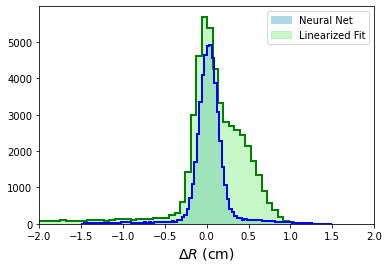

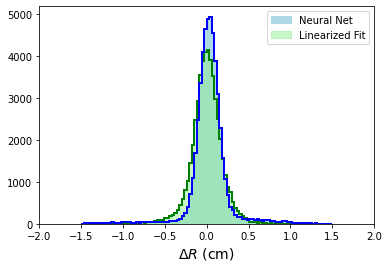

In [19]:
# plots the residual without the shebyshev correction
plt.hist(rst-rmc,bins=100,range=(-1.5,1.5),histtype='step',fill=True,color='lightblue',label = 'Neural Net',alpha = 1) 
plt.hist(rml-rmc,bins=100,range=(-5,1.5),histtype='step',fill=True,color='lightgreen',label = 'Linearized Fit',alpha = 0.5)
plt.hist(rml-rmc,bins=100,range=(-5,1.5),histtype='step',fill=False,color='green',linewidth = 2)
plt.hist(rst-rmc,bins=100,range=(-1.5,1.5),histtype='step',fill=False,color='blue',linewidth = 2)
plt.xlabel('$\\Delta R$ (cm)',fontsize=14)
plt.xlim(-2,2)
#plt.ylim(0,6000)
plt.legend(loc="upper right")
plt.show()

# shows the residual with the Shebyshev correction
plt.hist(rst-rmc,bins=100,range=(-1.5,1.5),histtype='step',fill=True,color='lightblue',label = 'Neural Net',alpha = 1)
plt.hist(fout_lijst-chebyfit(r2_lijst),bins=100,range=(-1.5,1.5),histtype='step',fill=True,color='lightgreen',label = 'Linearized Fit',alpha=0.5)
plt.hist(fout_lijst-chebyfit(r2_lijst),bins=100,range=(-1.5,1.5),histtype='step',fill=False,color='green',linewidth = 2)
plt.hist(rst-rmc,bins=100,range=(-1.5,1.5),histtype='step',fill=False,color='blue',linewidth = 2)
plt.xlabel('$\\Delta R$ (cm)',fontsize=14)
plt.xlim(-2,2)
#plt.ylim(0,5000)
plt.legend(loc="upper right")
plt.show()

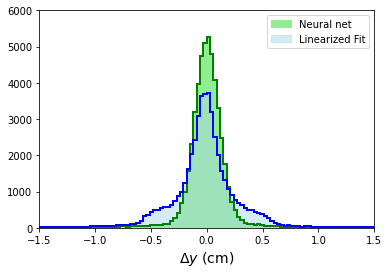

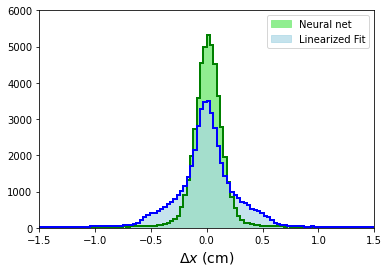

In [20]:
# shows the corrected residual on Y
correctie_y = ((fout_lijst - chebyfit(r2_lijst))* yml_lijst) /rml
plt.hist(yst_lijst -ymc_lijst ,bins=100,range=(-1.5,1.5),histtype='step',fill=True,color='lightgreen',label = 'Neural net')
plt.hist(yml_lijst -correctie_y -ymc_lijst ,bins=100,range=(-1.5,1.5),histtype='step',fill=True,color='lightblue',label = 'Linearized Fit',alpha=0.5)
plt.hist(yst_lijst -ymc_lijst ,bins=100,range=(-1.5,1.5),histtype='step',fill=False,color='green',linewidth = 2)
plt.hist(yml_lijst -correctie_y -ymc_lijst ,bins=100,range=(-1.5,1.5),histtype='step',color='blue',linewidth = 2)
plt.xlabel('$\\Delta y$ (cm)',fontsize=14)
plt.ylim(0,6000)
plt.xlim(-1.5,1.5)
plt.legend(loc="upper right")
plt.show()

# shows the corrected residual on X
correctie_x = ((fout_lijst - chebyfit(r2_lijst))* xml_lijst) /rml
plt.hist(xst_lijst -xmc_lijst ,bins=100,range=(-1.5,1.5),histtype='step',fill=True,color='lightgreen',label = 'Neural net')
plt.hist(xml_lijst -correctie_x -xmc_lijst ,bins=100,range=(-1.5,1.5),histtype='step',fill=True,color='lightblue',label = 'Linearized Fit',alpha=0.7)
plt.hist(xst_lijst -xmc_lijst ,bins=100,range=(-1.5,1.5),histtype='step',fill=False,color='green',linewidth = 2)
plt.hist(xml_lijst -correctie_x -xmc_lijst ,bins=100,range=(-1.5,1.5),histtype='step',fill=False,color='blue',linewidth = 2)
plt.xlabel('$\\Delta x$ (cm)',fontsize=14)
plt.ylim(0,6000)
plt.xlim(-1.5,1.5)
plt.legend(loc="upper right")
plt.show()

0.002971717667579651


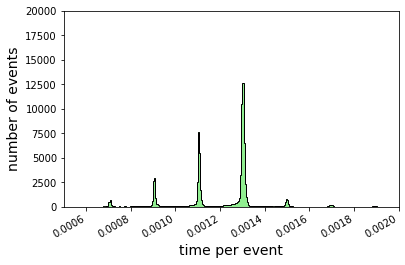

In [21]:
totale_tijd = sum(tijd_lijst)
print(totale_tijd/100000)

# plots time needed per event
fig, ax = plt.subplots()
ax.hist(tijd_lijst,bins=300,range=(0.0005,0.002),histtype='step',fill=True,color='lightgreen')
ax.hist(tijd_lijst,bins=300,range=(0.0005,0.002),histtype='step',fill=False,color='black')
fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
plt.xlabel("time per event",fontsize=14)
plt.ylabel("number of events",fontsize=14)
plt.xlim(0.0005,0.002)
plt.ylim(0,20000)
plt.show()